<a href="https://colab.research.google.com/github/deepjyotisaha85/eva4/blob/master/session6/Solution_EVA4S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.15
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value),
        ) # output_size = 26, receptive field: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value),
        ) # output_size = 24, , receptive field: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
        ) # output_size = 22, receptive field: 7

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 22, receptive field: 7

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, receptive field: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
        ) # output_size = 9, receptive field: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 7, receptive field: 16

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 5, receptive field: 20
    
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1, receptive field: 28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, receptive field: 28

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, receptive field: 28

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, receptive field: 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x) 
        x = self.convblock8(x)       
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
model1 = Net().to(device)
model2 = Net().to(device)
model3 = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 20, 22, 22]           1,800
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
          Dropout-10           [-1, 20, 22, 22]               0
           Conv2d-11           [-1, 10, 22, 22]             200
        MaxPool2d-12           [-1, 10, 11, 11]               0
           Conv2d-13             [-1, 10, 9, 9]             900
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
final_test_results=[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    final_test_results=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    #final_test_results.append(test_losses)
    #final_test_results.append(test_acc)
    #print("inisde test function...",final_test_results)
    return test_losses,test_acc

# Let's Train and test our model

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/model-40-epoch.pt'
torch.save(model, PATH)

In [0]:
def l1_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for parameter in model.parameters():
      reg_loss += l1_crit(parameter, loss)
    factor = 0.00025
    loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    


In [15]:
from torch.optim.lr_scheduler import StepLR
# Case 1: Training for 40 Epocs
testloss = []
testacc = []
testloss1 = []
testacc1 = []
testloss2 = []
testacc3 = []
testloss4 = []
testacc4 = []
EPOCHS = 1
for i in range(2):
  for epoch in range(EPOCHS):
    if i == 0:
      print("CASE_1: without L1andL2 with BN")
      print("EPOCH:", epoch)
      #model =  Net().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      train(model, device, train_loader, optimizer, epoch)
      testloss,testacc = test(model, device, test_loader)
      #print(type(results1))
      #print(results1)
    elif i == 1:
      print("CASE_2: with L1 with BN")
      print("EPOCH:", epoch)
      #model1 =  Net().to(device)
      optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      l1_train(model1, device, train_loader, optimizer, epoch)
      testloss1,testacc1 = test(model1, device, test_loader)
      #print(results2)
    elif i == 2:
      print("CASE_3: with L2 with BN")
      print("EPOCH:", epoch)
      #model2 =  Net().to(device)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(model2.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      train(model2, device, train_loader, optimizer, epoch)
      testloss2,testacc2 =test(model2, device, test_loader)
    elif i ==3:
      print("CASE_4: with L1andL2 with BN")
      print("EPOCH:", epoch)
      #model3 =  Net().to(device)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(model3.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      l1_train(model3, device, train_loader, optimizer, epoch)
      testloss3,testacc3 =test(model3, device, test_loader)    


  0%|          | 0/469 [00:00<?, ?it/s]

CASE_1: without L1andL2 with BN
EPOCH: 0


Loss=0.03767060115933418 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9863/10000 (98.63%)

CASE_2: with L1 with BN
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])


Test set: Average loss: 0.0483, Accuracy: 9855/10000 (98.55%)



In [16]:
print(testloss)
print(testacc)
print(testloss1)
print(testacc1)

[0.04663160467147827, 0.04825332446098328]
[98.63, 98.55]
[0.04663160467147827, 0.04825332446098328]
[98.63, 98.55]


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(1,4)
  print("================= Case 2: L1 40 Epocs ===============")
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  axs[0].plot(results1[i][0])
  axs[0].set_title("Test Loss")
  axs[1].plot(results1[i][1])
  axs[1].set_title("Test Accuracy")
  plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

CASE_1: without L1andL2 with BN
CASE_2: with L1 with BN
CASE_3: with L2 with BN
CASE_4: with L1andL2 with BN


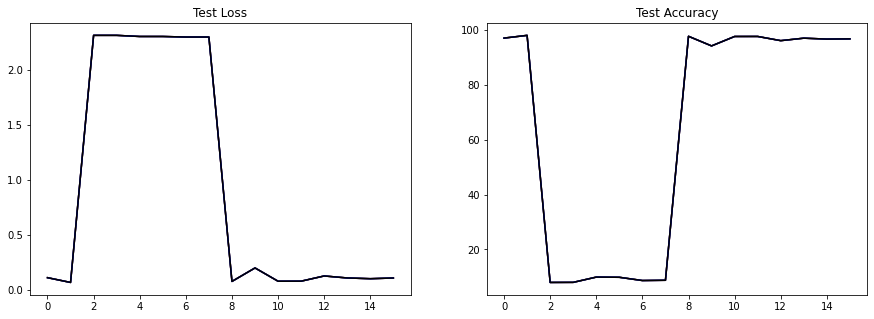

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
for i in range(1,5):
  if i == 1:
    print("CASE_1: without L1andL2 with BN")

    axs[0].plot(results1[0],color='red')
    axs[0].set_title("Test Loss123")
    axs[1].plot(results1[1],color='red')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 2:
    print("CASE_2: with L1 with BN")
    
    axs[0].plot(results2[0],color='green')
    axs[0].set_title("Test Loss456")
    axs[1].plot(results2[1],color='green')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 3:
    print("CASE_3: with L2 with BN")
    
    axs[0].plot(results3[0],color='blue')
    axs[0].set_title("Test Loss")
    axs[1].plot(results3[1],color='blue')
    axs[1].set_title("Test Accuracy123")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 4:
    print("CASE_4: with L1andL2 with BN")
    
    axs[0].plot(results4[0], color='black')
    axs[0].set_title("Test Loss")
    axs[1].plot(results4[1], color='black')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')